# Наивный Байес и спам
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW08] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [40]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import spacy
import nltk
from nltk.stem.snowball import SnowballStemmer
from collections import defaultdict

In [5]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [6]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train, voc_limit=v)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [7]:
X, y = read_dataset("spam")

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

/Users/faridbag/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Задание 1 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [28]:
class NaiveBayes:
    def __init__(self, alpha):
        self.alpha = alpha 
    
    def fit(self, X, y, voc_limit=1000):
        self.classes = np.unique(y)
        self.vl = voc_limit
        self.cls_probs = {cls:0 for cls in self.classes}
        self.probs = {cls:defaultdict(lambda: defaultdict(int)) for cls in self.classes}
        for x, cls in zip(X, y):
            self.cls_probs[cls] += 1 / len(y)
            cd = defaultdict(int)
            for v in x:
                if v >=0:
                    cd[v] += 1
                    if cd[v] > 9:
                        cd[v] = 9
            for v in range(voc_limit):
                self.probs[cls][v][cd[v]] += 1
        
        for cls in self.classes:
            tot = self.cls_probs[cls] * len(y) + 10 * self.alpha
            for x in self.probs[cls]:
#                 tot = sum(self.probs[cls][x].values())
                for am in range(10):
                    self.probs[cls][x][am] = (self.probs[cls][x][am] + self.alpha) / tot
        
    def predict(self, X):
        return [self.classes[i] for i in np.argmax(self.log_proba(X), axis=1)]
    
    def log_proba(self, X):
        res = np.zeros((X.shape[0], len(self.classes)))
        for i, x in enumerate(X):
            cd = defaultdict(int)
            for v in x:
                if v >=0:
                    cd[v] += 1
                    if cd[v] > 9:
                        cd[v] = 9
            for j, cls in enumerate(self.classes):
                res[i, j] = np.log(self.cls_probs[cls]) 
                for w in range(self.vl):
                    res[i, j] += np.log(self.probs[cls][w][cd[w]])
        return res

In [97]:
class NaiveBayes2:
    def __init__(self, alpha):
        self.alpha = alpha 
    
    def fit(self, X, y, voc_limit=1000):
        self.classes = np.unique(y)
        self.vl = voc_limit
        self.cls_probs = {cls:self.alpha for cls in self.classes}
        self.probs = {cls: {i:self.alpha for i in range(self.vl)} for cls in self.classes}
        for x, cls in zip(X, y):
            self.cls_probs[cls] += 1 / len(y)
            for v in x:
                if v >=0:
                    self.probs[cls][v] += 1

        
        for cls in self.classes:
            tot = sum(self.probs[cls].values())
            for x in self.probs[cls]:
                self.probs[cls][x] /= tot
        
    def predict(self, X):
        return [self.classes[i] for i in np.argmax(self.log_proba(X), axis=1)]
    
    def log_proba(self, X):
        res = np.zeros((X.shape[0], len(self.classes)))
        for i, x in enumerate(X):
            cd = defaultdict(int)
            for v in x:
                if v >=0:
                    cd[v] += 1
                    if cd[v] > 9:
                        cd[v] = 9
            for j, cls in enumerate(self.classes):
                res[i, j] = np.log(self.cls_probs[cls]) 
                for w in range(self.vl):
                    res[i, j] += np.log(self.probs[cls][w]) * cd[w]
        return res

### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [56]:
tok = nltk.tokenize.TweetTokenizer()

In [60]:
class BoW:
    def __init__(self, X, voc_limit=1000):
        voc_all = {}
        for x in X:
            for word in tok.tokenize(x.lower()):
                if word in voc_all:
                    voc_all[word] += 1
                else:
                    voc_all[word] = 1
        keys = sorted(voc_all, key=lambda x: voc_all[x], reverse=True)
        self.voc = []
        cnt = 0
        for key in keys:
            self.voc.append(key)
            cnt += 1
            if cnt >= voc_limit:
                break
        self.word2id = {self.voc[i]:i for i in range(len(self.voc))}
                
    def transform(self, X):
        res = []
        for x in X:
            vec_x = []
            for word in tok.tokenize(x.lower()):
                if word in self.word2id:
                    vec_x.append(self.word2id[word])
                else:
                    vec_x.append(-1)
            res.append(np.array(vec_x))
        return np.array(res)

In [61]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [99]:
predictor = NaiveBayes2(0.001)
predictor.fit(X_train_bow, y_train, voc_limit=500)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.9873949579831933, 'spam': 0.926829268292683},
 {'ham': 0.9873949579831933, 'spam': 0.926829268292683},
 0.978494623655914)

In [100]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train, voc_limit=500)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.9874476987447699, 'spam': 0.95},
 {'ham': 0.9915966386554622, 'spam': 0.926829268292683},
 0.982078853046595)

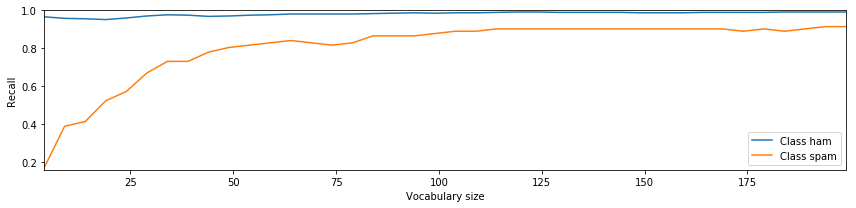

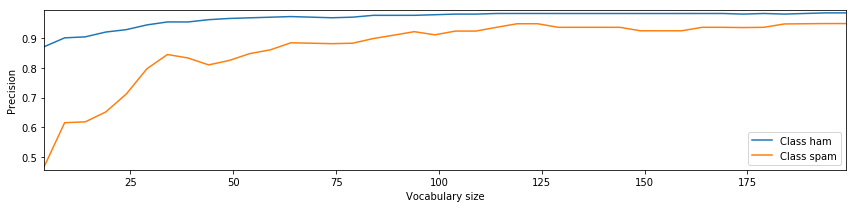

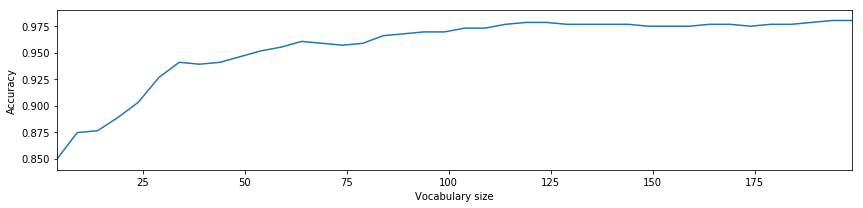

In [63]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [34]:
stemmer = SnowballStemmer("english")

In [64]:
class BowStem:
    def __init__(self, X, voc_limit=1000):
        voc_all = {}
        for x in X:
            for word in tok.tokenize(x.lower()):
                word = stemmer.stem(word)
                if word in voc_all:
                    voc_all[word] += 1
                else:
                    voc_all[word] = 1
        keys = sorted(voc_all, key=lambda x: voc_all[x], reverse=True)
        self.voc = []
        cnt = 0
        for key in keys:
            self.voc.append(key)
            cnt += 1
            if cnt >= voc_limit:
                break
        self.word2id = {self.voc[i]:i for i in range(len(self.voc))}
                
    def transform(self, X):
        res = []
        for x in X:
            vec_x = []
            for word in tok.tokenize(x.lower()):
                word = stemmer.stem(word)
                if word in self.word2id:
                    vec_x.append(self.word2id[word])
                else:
                    vec_x.append(-1)
            res.append(np.array(vec_x))
        return np.array(res)

In [65]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [101]:
predictor = NaiveBayes2(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.9894291754756871, 'spam': 0.9058823529411765},
 {'ham': 0.9831932773109243, 'spam': 0.9390243902439024},
 0.9767025089605734)

In [66]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.9874476987447699, 'spam': 0.95},
 {'ham': 0.9915966386554622, 'spam': 0.926829268292683},
 0.982078853046595)

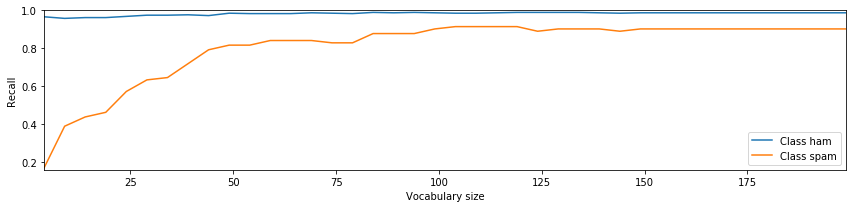

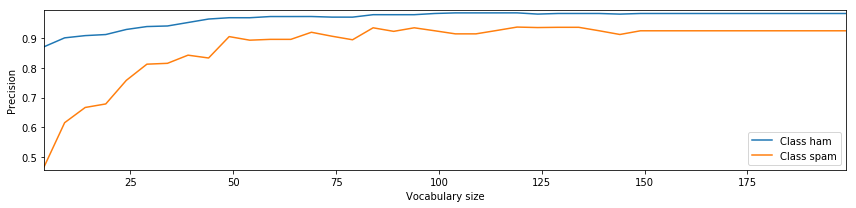

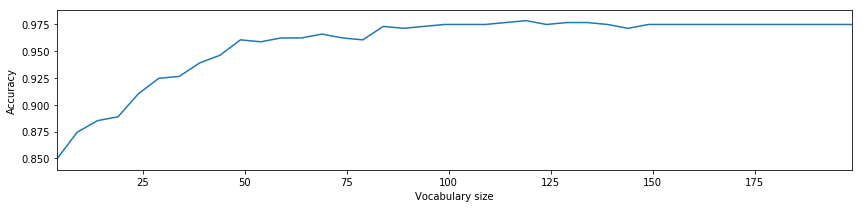

In [67]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)

In [68]:
lol = 12e-4

In [69]:
lol

0.0012

In [79]:
print(f"{lol:2.3f}")
print(f"{-lol:2.3f}")

0.001
-0.001
